## Population Dynamics in King County, WA during COVID-19
### How does vaccination and mask usage affect the disease dynamics of COVID-19?
Regina-Mae Dominguez
DATA 512
Autumn 2022

### The Susceptible, Vaccinated, Exposed, Infected, and Recovered (SVEIR) Compartment Model
Due to its simple form, the SIR (Susceptible, Infected, and Recovered) model informs you how the rate of transmission would affect the individuals when separating its population into compartments. Extending a simple SIR compartment model to include a vaccination compartment to determine how individuals would be affected if a vaccine was initially implemented during the start of COVID-19 and how it will continue to look through the next years to come. This analysis can help researchers and community officials determine and predict whether or not their current vaccine efforts are effectively preventing the spread of the disease. This will help humans and individuals to understand the dangers of COVID-19 from a different perspective, furthermore, these predictions can help determine the behaviors in which individuals decide to act for the benefit of their health.

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

### Data Used
In addition to what was used in the first part of this project, (the John Hopkins University data on COVID-19 and the NY times mask mandate survey), we will also use data taken from
- the King County COVID-19 government site,
- the Washington Department of Health, and
- the Centers for Disease Control and Prevention.

In [23]:
## The King County COVID-19 health data

# vaccination data
vaccination_data = pd.read_csv("vax_public.csv")

# death by COVID-19 data
kc_covid_data = pd.read_csv("COVID19_King-County.csv")

In [55]:
# John Hopkins University Data (CLEANED FROM FIRST PART)
kc_fixed_rates = pd.read_csv("KC_fixed_cases.csv")

# NY Times Mask Use
mask_use = pd.read_csv("mask-use-by-county.csv")
kc_mask_use = mask_use[mask_use['COUNTYFP'] == 53033]

### Assumptions to the model
Computation is limited to be from February 1, 2020 to October 31, 2021 which is the time period that was set in Part 1. However, this can give us a sense to how the pandemic would look in the early stages as well. Other assumptions include:
- The entire population is susceptible and equally susceptible.
- This is a closed system and no other factors play a role in these dynamics.

### Photo of Created Compartment Model
![compartment_model](CompartmentModel.JPG)

The compartment model can be modeled by a set of differential equations which can be seen here:
![ode](ODE.JPG)

Looking at these differential equations, we can see the parameters that we need to compute and how/where we will derive these values:
- $\Pi$: birth rate: Taken from Washington Health Department
- $\beta$: infectious rate: We will compute this by computing the retransmission rate: the average sum of cases today divided by the average sum of cases yesterday.
- $\kappa$: incubation rate: Taken from CDC guideline
- $\sigma$: recovery rate: Taken from CDC guideline
- $\gamma$: loss of immunity: Taken from CDC guideline
- $d$: disease induced death: We will compute this by getting the total number of COVID-19 deaths and dividing it by the total number of COVID-19 cases to proportion it to COVID-19.
- $\alpha$: vaccination rate: We will get this by computing the average of total number of people vaccinated daily divided by the population. We will only consider those who receieved their second dose of vaccinations to be fully vaccinated.
- $\omega$: wanning rate of vaccine: Taken from CDC guideline
- $\mu$: natural death rate: Taken from Washington Health Department
- $\rho$: mask usage proportion: Taken from NY Times Survey

### Getting Parameters/Data Cleaning

In [143]:
## getting mask proportion
kc_mask_use.head()
mask_usage = kc_mask_use['ALWAYS'].iloc[0]

0.7240000000000001

In [159]:
# Start with getting vaccination rate (alpha)

# date range from 2/1/2021 - 10/31/2021
vaccination_data['new_date_format'] = pd.to_datetime(vaccination_data['date'])
vaccination_data = vaccination_data[(vaccination_data['new_date_format'] >= "2021-02-01") & (vaccination_data['new_date_format'] <= "2021-10-31")]
# assume vaccination after fully vaccinated (the 2nd dose)
vaccination_data['Fully_Vaccinated'] = vaccination_data["Primary mRNA dose 2"]
vaccination_data['Vax_Proportion_Per_Day'] = vaccination_data['Fully_Vaccinated']/vaccination_data['Population']

# get vaccination rate
vax_rate = vaccination_data['Vax_Proportion_Per_Day'].mean()

In [37]:
## parameter for 30% prop initially vaccinated
population_thirty_percent = vaccination_data['Population'].iloc[1]*.3
vaccination_data['hypothesized_fully_vax'] = vaccination_data['Fully_Vaccinated']
vaccination_data.loc[0, 'hypothesized_fully_vax'] = vaccination_data['Fully_Vaccinated'].iloc[0] + population_thirty_percent
vaccination_data['hypo_vax_prop_per_day'] = vaccination_data['hypothesized_fully_vax']/vaccination_data['Population']

# hypothesized vaccination rate
hypo_vax_rate = vaccination_data['hypo_vax_prop_per_day'].mean()

In [120]:
## get infectious rate
kc_fixed_rates = kc_fixed_rates[(kc_fixed_rates['new_date_format'] >= "2021-02-01") & (kc_fixed_rates['new_date_format'] <= "2021-10-31")]
kc_fixed_rates['population'] = vaccination_data['Population'].iloc[0]

kc_fixed_rates['retransmission'] = kc_fixed_rates['daily_cases'].div(kc_fixed_rates['daily_cases'].shift(1))
kc_fixed_rates['retransmission_div_pop'] = kc_fixed_rates['retransmission']/kc_fixed_rates['population']
kc_fixed_rates['case_by_pop'] = kc_fixed_rates['daily_cases'] / kc_fixed_rates['population']
#remove na or inf
kc_without_na = kc_fixed_rates
kc_without_na = kc_without_na[(kc_without_na['retransmission_div_pop']!=np.inf)]
kc_without_na = kc_without_na[(kc_without_na['retransmission_div_pop']!= -np.inf)]

kc_without_na = kc_without_na.fillna(0)
#kc_without_first = kc_fixed_rates.tail(-1)
val = kc_without_na['retransmission_div_pop'].mean()


In [74]:
## death data

kc_covid_data['new_date_format'] = pd.to_datetime(kc_covid_data['date'])
kc_covid_data = kc_covid_data[(kc_covid_data['new_date_format'] >= "2021-02-01") & (kc_covid_data['new_date_format'] <= "2021-10-31")]

total_deaths = kc_covid_data['death_count'].sum()
disease_induced_death = total_deaths/kc_covid_data['case_count'].sum()

### Center for Disease Control and Prevention Computations
Other rates come from said CDC guidelines, such as,
- incubation rate: It takes about 3-5 days to develop symptoms after being exposed (if sympotmatic), thus we will assume the rate will be 1/4.
- recovery rate: After having COVID-19, it takes about 2 weeks to be fully recovered from the virus, thus we will assume the rate will be 1/14.
- loss of immunity: After you have COVID-19, it is said that you are less likely to contract COVID-19 again within 3 months, thus we will assume the rate will be 1/90.
- Wanning rate of vaccine: It is recommended you get a booster after 4-6 months, thus we will use 1/120 as the wanning rate of the vaccine.

### Demographic Rates Computation
To get parameters for birth rate and natural death rate, we look at the values from the Washington Health Department online dashboards [For Births](https://doh.wa.gov/data-statistical-reports/washington-tracking-network-wtn/birth-outcomes/county-all-births-dashboard-0) and [For Deaths](https://doh.wa.gov/data-statistical-reports/washington-tracking-network-wtn/death/county-all-deaths-dashboard). For these values, we take the value from 2019 as we assume that COVID-19 could have affected the proportion of birth and deaths.
- Birth Rate: In 2019, there was a total of 24,090 births. We will take this value and divide it by 365 to get the value daily. Thus, 24090/365 is approximately 66.
- Death Rate: In 2019, there was approximately 13,463 deaths. We will take this value and divide it by 365 to get the value per day, then divide by the total population in 2019 (2226300) to get the rate per day. Thus, 13463/365/2226300 is approximately 0.0000165.

In [75]:
# function
def deriv(y, t, Pi, beta, kappa, omega, gamma, d, alpha, sigma, mu, rho):
    S, V, E, I, R, D = y
    dSdt = Pi + omega*V + gamma*R - mu*S - alpha*S - beta*(1-rho)*S*I
    dVdt = alpha*S - mu*V - omega*V
    dEdt = beta*(1 - rho)*S*I - kappa*E - mu*E
    dIdt = kappa*E - sigma*I - d*I - mu*I
    dRdt = sigma*I - gamma*R - mu*R
    dDdt = d*I
    return dSdt, dVdt, dEdt, dIdt, dRdt, dDdt

In [146]:
# parameters
Pi = 24090/365
alpha = 0.00236
omega = 1/120
beta =  .0000005785
#beta = val
kappa =  1/4
d = 750/23300
#d = disease_induced_death
sigma = 1/14
mu = 13463/2226300/365
gamma = 1/90
rho = mask_usage

In [147]:
# initial conditions
S0=2260799 # population amount
V0=0
E0=0
I0=1
R0=0
D0=0

Y0 = S0, V0, E0, I0, R0, D0

In [148]:
# time iis 500 days
t = np.arange(501)

In [149]:
ret = odeint(deriv, Y0, t, args=(Pi, beta, kappa, omega, gamma, d, alpha, sigma, mu, rho))
S, V, E, I, R, D = ret.T

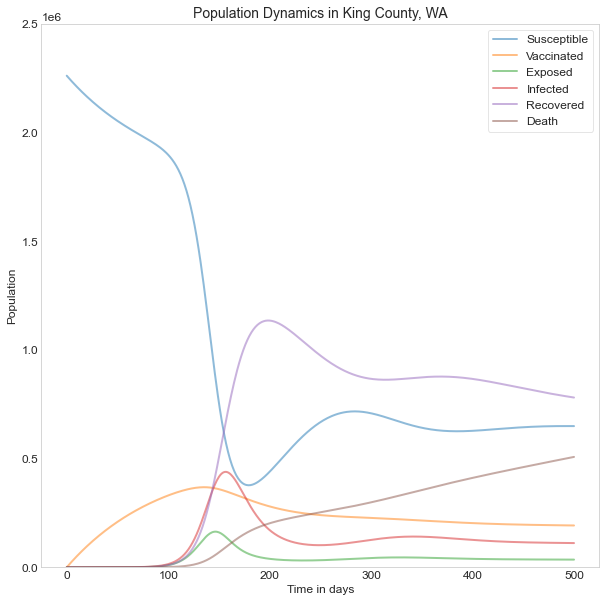

In [145]:
fig = plt.figure(figsize=(10,10))
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

ax = fig.add_subplot(111, facecolor='#FFFFFF', axisbelow=True)
ax.plot(t, S,  alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, V,  alpha=0.5, lw=2, label='Vaccinated')
ax.plot(t, E,  alpha=0.5, lw=2, label='Exposed')
ax.plot(t, I,  alpha=0.5, lw=2, label='Infected')
ax.plot(t, R,  alpha=0.5, lw=2, label='Recovered')
ax.plot(t, D,  alpha=0.5, lw=2, label='Death')
ax.set_xlabel('Time in days')
ax.set_ylabel('Population')
ax.set_ylim(0,2500000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(prop = {'size': 12})
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
  #  ax.spines[spine].set_visible(False)
plt.title("Population Dynamics in King County, WA", fontsize = 14)
plt.show()

## First hypothesis: The introduction of a vaccine with a vaccination level of at least 30% of the population, in a closed system, will decrease the disease death count by at least 2%.

In [150]:
alpha = 0.00366

In [151]:
ret2 = odeint(deriv, Y0, t, args=(Pi, beta, kappa, omega, gamma, d, alpha, sigma, mu, rho))
S2, V2, E2, I2, R2, D2 = ret2.T

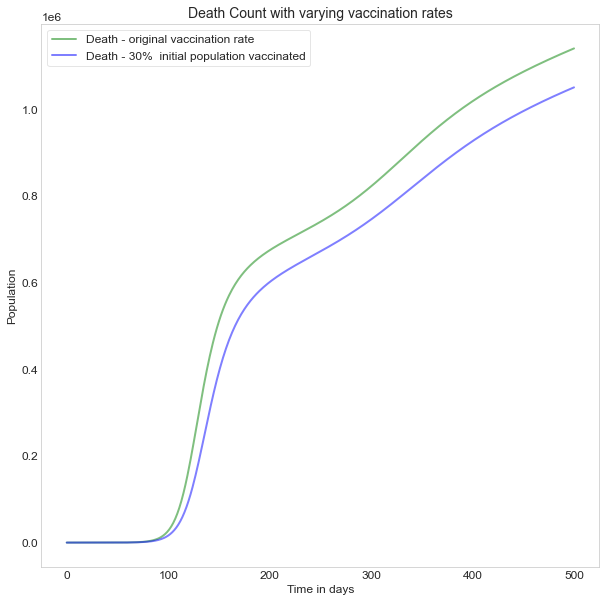

In [157]:
fig = plt.figure(figsize=(10,10), facecolor='w')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
ax = fig.add_subplot(111,  axisbelow=True)
ax.plot(t, D, 'g', alpha=0.5, lw=2, label='Death - original vaccination rate')
ax.plot(t, D2, 'b', alpha=0.5, lw=2, label='Death - 30%  initial population vaccinated')

ax.set_xlabel('Time in days')
ax.set_ylabel('Population')
#ax.set_ylim(0,3000000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(prop = {'size': 12})
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
 #   ax.spines[spine].set_visible(False)
plt.title("Death Count with varying vaccination rates", fontsize=14)
plt.show()

In [154]:
max(D2)

1050205.0811042644

In [155]:
max(D)

1140060.3511368881

In the plot above, you can see that the max number of deaths decreases with a higher proportion of the population initially vaccinated.

## Second hypothesis: Adding a masking proportion of at least 40% of the population will slow the spread of the disease by about 10 days.

In [133]:
# no masking component
rho = 0

In [134]:
ret3 = odeint(deriv, Y0, t, args=(Pi, beta, kappa, omega, gamma, d, alpha, sigma, mu, rho))
S3, V3, E3, I3, R3, D3 = ret3.T

In [135]:
# masking 40% percent
rho = 0.4

In [136]:
ret4 = odeint(deriv, Y0, t, args=(Pi, beta, kappa, omega, gamma, d, alpha, sigma, mu, rho))
S4, V4, E4, I4, R4, D4 = ret4.T

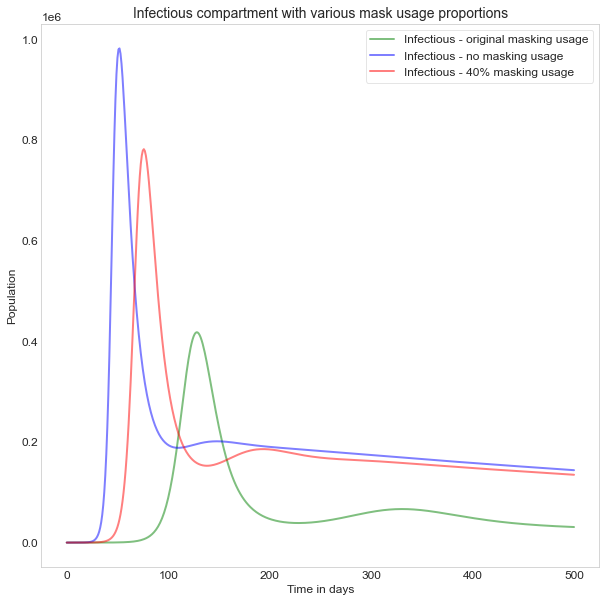

In [158]:
fig = plt.figure(figsize=(10,10), facecolor='w')
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

ax = fig.add_subplot(111, axisbelow=True)
ax.plot(t, I, 'g', alpha=0.5, lw=2, label='Infectious - original masking usage')
ax.plot(t, I3, 'b', alpha=0.5, lw=2, label='Infectious - no masking usage')
ax.plot(t, I4, 'r', alpha=0.5, lw=2, label='Infectious - 40% masking usage')
ax.set_xlabel('Time in days')
ax.set_ylabel('Population')
#ax.set_ylim(0,3000000)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend(prop = {'size': 12})
legend.get_frame().set_alpha(0.5)
#for spine in ('top', 'right', 'bottom', 'left'):
 #   ax.spines[spine].set_visible(False)
plt.title("Infectious compartment with various mask usage proportions", fontsize = 14)
plt.show()

In the plot above, you can see that the hypothesis is proven true. The disease definitely slows down between the different mask usage values.